In [50]:
!pip install shap

import time
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import shap
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score

n_iter = 50

def create_dataset():
    meta_features = pd.read_csv('ClassificationAllMetaFeatures.csv')
    winner = pd.read_csv('results_winner.csv')
    meta_datset = pd.DataFrame()

    for _, row in meta_features.iterrows():
        dataset_name = row['dataset']
        mf = row.drop('Unnamed: 143')
        meta_winner = winner[winner['Dataset Name'] == dataset_name]
        for _, w_row in meta_winner.iterrows():
            new_meta = mf.copy()
            new_meta['Algorithm Name'] = w_row['Algorithm Name']
            new_meta['Winner'] = w_row['Winner']
            meta_datset = meta_datset.append(new_meta, ignore_index=True)
    meta_datset.to_csv('meta_dataset_plus_dataset_column.csv', index=False)

In [51]:
def to_dict(X):
    return X.to_dict("records")

def get_datasets_groups(df):
    df = pd.read_csv('meta_dataset_plus_dataset_column.csv')
    groups_array_size = df.shape[0]
    groups = np.zeros(groups_array_size)

    for idx in range(groups_array_size):
        groups[idx] = idx // 3 + 1
    
    return groups

def get_average_precision_score(y_true, y_pred_prob):
    return average_precision_score(y_true, y_pred_prob[:, 1], pos_label=y_true.iloc[0])

def get_fpr_tpr(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1], pos_label=y_true.iloc[0])

    for idx, th in enumerate(thresholds):
        if th < 0.5:
            return fpr[idx - 1], tpr[idx - 1], auc(fpr, tpr)

    raise Exception('Invalid roc curve')

def train_test_leave_one_out():
    res = pd.DataFrame()
    logo = LeaveOneGroupOut()
    df = pd.read_csv('meta_dataset_plus_dataset_column.csv')
    X = df.drop('Winner', axis=1)
    y = df['Winner']
    groups = get_datasets_groups(X)
    roc_auc_sum = 0

    for idx, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        dataset_name = X_test.iloc[0, :]['dataset']
        X_train = X_train.drop('dataset', axis=1)
        X_test = X_test.drop('dataset', axis=1)
        dict_transformer = FunctionTransformer(to_dict, validate=False)
        pipeline = Pipeline([
            ('dict_transformer', dict_transformer),
            ('vectorizer', DictVectorizer(sparse=False)),
            ('clf', xgb.XGBClassifier(max_depth=3))
        ])
        gbm_param_grid = {
            'clf__n_jobs': [-1],
            'clf__learning_rate': np.arange(0.05, 1, 0.05),
            'clf__max_depth': np.arange(3, 50, 1),
            'clf__n_estimators': np.arange(50, 1000, 50),
            'clf__colsample_bytree': np.arange(0.1, 1.05, 0.05),
        }
        clf = RandomizedSearchCV(estimator=pipeline, param_distributions=gbm_param_grid, n_jobs=-1,
                                 n_iter=n_iter, scoring='roc_auc', verbose=1, cv=3, random_state=42)
        inf_curr_time = time.perf_counter()
        clf.fit(X_train, y_train)
        inf_elasped_time = time.perf_counter()
        y_pred = clf.predict(X_test)
        pred_curr_time = time.perf_counter()
        y_pred = clf.predict(X_test)
        pred_elasped_time = time.perf_counter()
        y_pred_prob = clf.predict_proba(X_test)
        fpr, tpr, roc_auc = get_fpr_tpr(y_test, y_pred_prob)
        accuracy = clf.score(X_test, y_test)
        roc_auc_sum += roc_auc
        df = pd.DataFrame({
            'Dataset Name Left Out': [dataset_name],
            'Cross Validation': [idx + 1],
            'Hyper-Parameters Values' : [clf.best_params_],
            'Accuracy': [accuracy_score(y_test, y_pred)],
            'TPR': [tpr],
            'FPR': [fpr],
            'Precision': [precision_score(y_test, y_pred, average='macro')],
            'AUC': [roc_auc],
            'PR-Curve': [get_average_precision_score(y_test, y_pred_prob)],
            'Training Time(time.perf_counter())': ['{:.2f}'.format(inf_elasped_time - inf_curr_time)],
            'Inference Time(time.perf_counter()': ['{:.2f}'.format(pred_elasped_time - pred_curr_time)]
        })
        
        res = res.append(df, ignore_index=True)
        
        res.to_csv('meta_results.csv', index=False)
        print('Done! Accuracy: {0}'.format(accuracy))
        print('Done! Roc Auc Mean: {0}'.format(roc_auc_sum / (idx + 1)))
        
create_dataset()
train_test_leave_one_out()



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 1.0
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 1.0
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.8333333333333334
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.75
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.8
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.8333333333333334
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.8571428571428571
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.875
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.8333333333333334
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.8
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.8181818181818182
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.75
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.7307692307692307
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.6785714285714286
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.6333333333333333
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.65625
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.6764705882352942
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.6944444444444444
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.7105263157894737
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.675
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.6428571428571429
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.6136363636363636
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5869565217391305
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.6041666666666666
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.6
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.6153846153846154
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5925925925925926
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5892857142857143
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5862068965517241
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5833333333333334
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5967741935483871
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.59375
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5757575757575758
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5588235294117647
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5714285714285714
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5694444444444444
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.581081081081081
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5657894736842105
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5769230769230769
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5875
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.573170731707317
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5595238095238095
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5465116279069767
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5568181818181818
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5666666666666667
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5652173913043478
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.574468085106383
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5729166666666666
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5816326530612245
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.58
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5686274509803921
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5769230769230769
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5660377358490566
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5740740740740741
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5636363636363636
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5714285714285714
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5614035087719298
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5517241379310345
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.559322033898305
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5583333333333333
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5491803278688525
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5564516129032258
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5555555555555556
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5625
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5538461538461539
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5606060606060606
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5597014925373134
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5661764705882353
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.572463768115942
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5714285714285714
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5774647887323944
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5694444444444444
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5753424657534246
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5675675675675675
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.56
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5592105263157895
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.551948051948052
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5576923076923077
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5632911392405063
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.56875
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5679012345679012
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5609756097560976
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5602409638554217
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5654761904761905
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5588235294117647
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5523255813953488
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5517241379310345
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5568181818181818
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5561797752808989
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5555555555555556
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5604395604395604
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5652173913043478
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5645161290322581
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5691489361702128
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5684210526315789
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5729166666666666
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5773195876288659
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5714285714285714
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5757575757575758
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.575
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5792079207920792
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5833333333333334
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.587378640776699
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5913461538461539
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5952380952380952
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5990566037735849
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5981308411214953
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5972222222222222
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.591743119266055
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5863636363636363
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5855855855855856
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5892857142857143
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5929203539823009
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5921052631578947
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5869565217391305
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5862068965517241
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5854700854700855
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5805084745762712
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5756302521008403
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5791666666666667
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5826446280991735
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5778688524590164
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5772357723577236
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5766129032258065
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.576
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5753968253968254
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5708661417322834
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.57421875
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.5736434108527132
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.573076923076923
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5763358778625954
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5795454545454546
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5827067669172933
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.5
Done! Roc Auc Mean: 0.582089552238806
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5777777777777777
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


Done! Accuracy: 0.0
Done! Roc Auc Mean: 0.5735294117647058
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Done! Accuracy: 1.0
Done! Roc Auc Mean: 0.5766423357664233


In [52]:
df = pd.read_csv('meta_dataset_plus_dataset_column.csv')
X = df.drop('Winner', axis=1)
X = X.drop('dataset', axis=1)
y = df['Winner']
X_dict = X.to_dict("records")
dv = DictVectorizer(sparse=False)
X_encoded = dv.fit_transform(X_dict)
clf = xgb.XGBClassifier(n_jobs=-1, n_estimators=750, max_depth=24, learning_rate=0.3, colsample_bytree=0.6)
clf.fit(X_encoded, y)
explainer = shap.TreeExplainer(clf, data=shap.sample(X_encoded, 100), model_output="predict_proba")

In [53]:
f_dict = {}
for idx, f_name in enumerate(dv.get_feature_names()):
  f_dict['f' + str(idx)] = f_name

full_importance_dict = {}

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    importance_dict = clf.get_booster().get_score(importance_type=importance_type)
    new_importance_dict = {}
    for key in importance_dict.keys():
      new_importance_dict[f_dict[key]] = importance_dict[key]
    full_importance_dict[importance_type] = new_importance_dict

full_importance_df = pd.DataFrame(full_importance_dict)

full_importance_df.to_csv('full_importance_df.csv')

In [54]:
shap.initjs()
data_for_prediction = X_encoded[5].reshape(1, -1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], dv.get_feature_names())

In [55]:
shap.initjs()
data_for_prediction = X_encoded[104].reshape(1, -1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], dv.get_feature_names())

In [56]:
shap.initjs()
data_for_prediction = X_encoded[201].reshape(1, -1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], dv.get_feature_names())

In [57]:
shap.initjs()
data_for_prediction = X_encoded[403].reshape(1, -1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], dv.get_feature_names())

In [58]:
shap.initjs()
data_for_prediction = X_encoded[410].reshape(1, -1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], dv.get_feature_names())

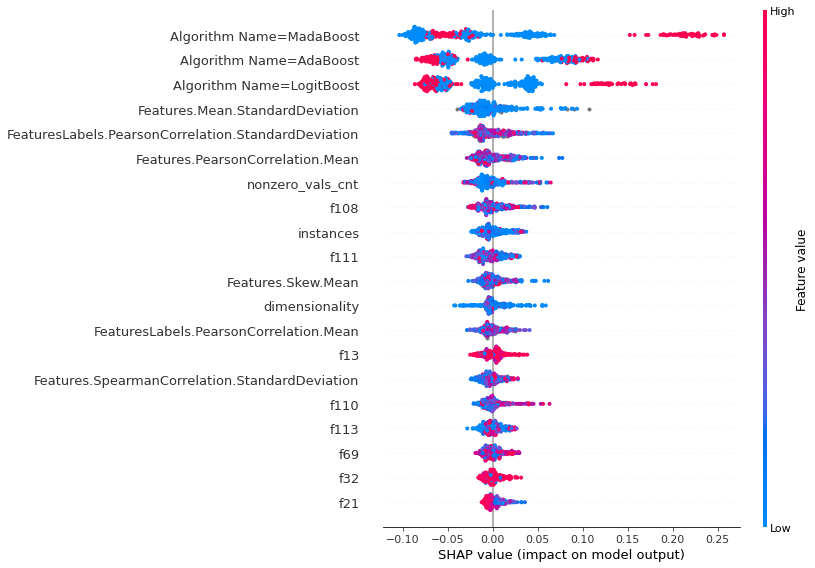

In [59]:
shap.initjs()
shap_values = explainer.shap_values(X_encoded)
shap.summary_plot(shap_values[1], X_encoded, dv.get_feature_names())   

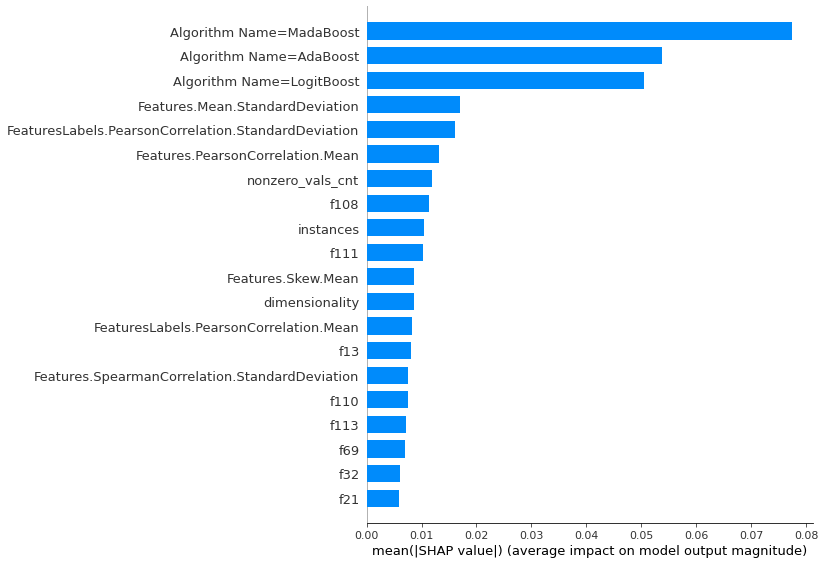

In [60]:
shap.initjs()
shap_values = explainer.shap_values(X_encoded)
shap.summary_plot(shap_values[1], X_encoded, dv.get_feature_names(), plot_type="bar")   

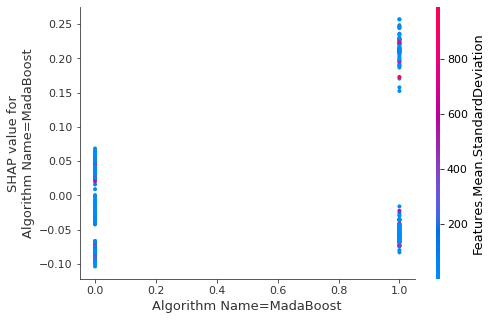

In [61]:
shap.initjs()
shap.dependence_plot('Algorithm Name=MadaBoost', shap_values[1], X_encoded, interaction_index="Features.Mean.StandardDeviation", feature_names=dv.get_feature_names())

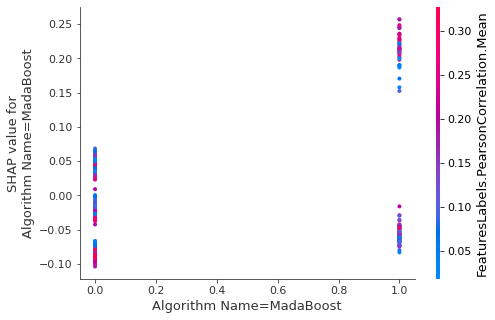

In [62]:
shap.initjs()
shap.dependence_plot('Algorithm Name=MadaBoost', shap_values[1], X_encoded, interaction_index="FeaturesLabels.PearsonCorrelation.Mean", feature_names=dv.get_feature_names())

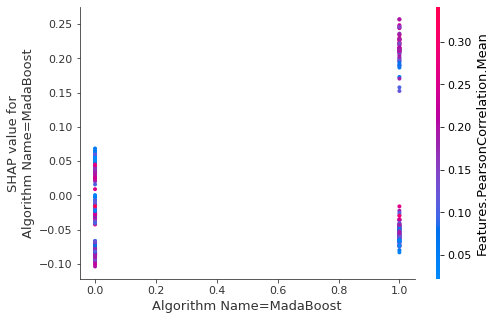

In [63]:
shap.initjs()
shap.dependence_plot('Algorithm Name=MadaBoost', shap_values[1], X_encoded, interaction_index="Features.PearsonCorrelation.Mean", feature_names=dv.get_feature_names())

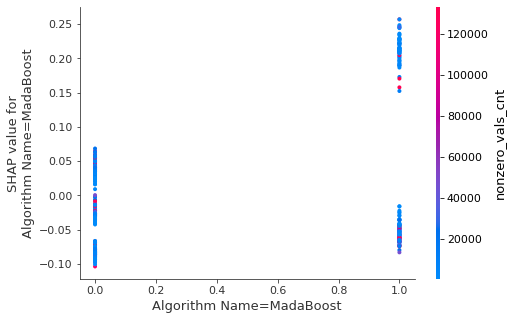

In [64]:
shap.initjs()
shap.dependence_plot('Algorithm Name=MadaBoost', shap_values[1], X_encoded, interaction_index="nonzero_vals_cnt", feature_names=dv.get_feature_names())

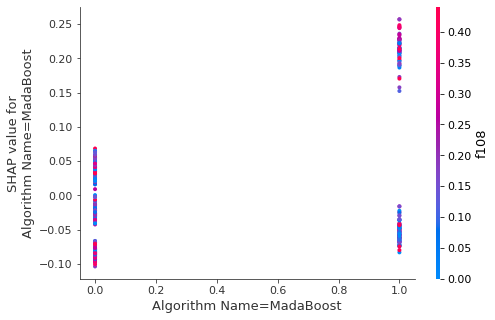

In [65]:
shap.initjs()
shap.dependence_plot('Algorithm Name=MadaBoost', shap_values[1], X_encoded, interaction_index="f108", feature_names=dv.get_feature_names())

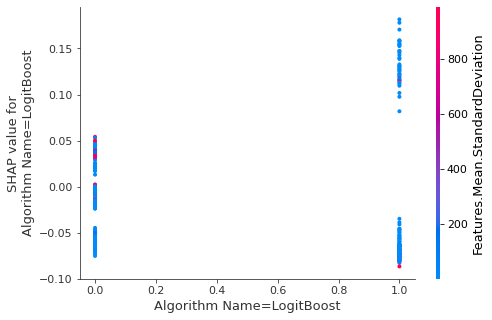

In [66]:
shap.initjs()
shap.dependence_plot('Algorithm Name=LogitBoost', shap_values[1], X_encoded, interaction_index="Features.Mean.StandardDeviation", feature_names=dv.get_feature_names())

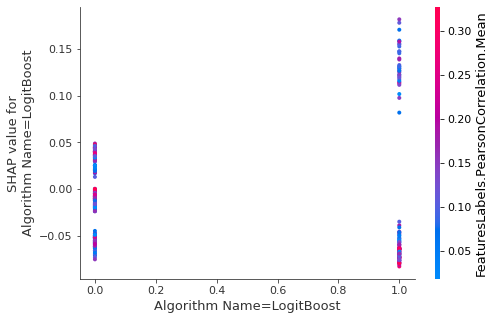

In [67]:
shap.initjs()
shap.dependence_plot('Algorithm Name=LogitBoost', shap_values[1], X_encoded, interaction_index="FeaturesLabels.PearsonCorrelation.Mean", feature_names=dv.get_feature_names())

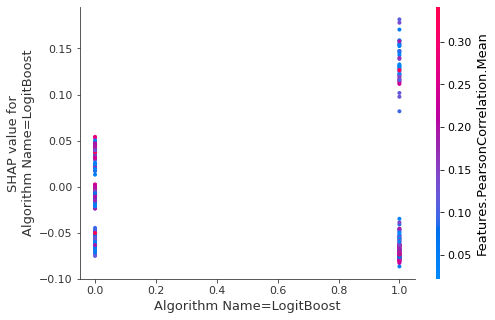

In [68]:
shap.initjs()
shap.dependence_plot('Algorithm Name=LogitBoost', shap_values[1], X_encoded, interaction_index="Features.PearsonCorrelation.Mean", feature_names=dv.get_feature_names())

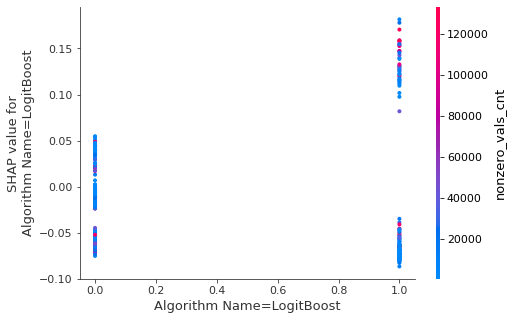

In [69]:
shap.initjs()
shap.dependence_plot('Algorithm Name=LogitBoost', shap_values[1], X_encoded, interaction_index="nonzero_vals_cnt", feature_names=dv.get_feature_names())

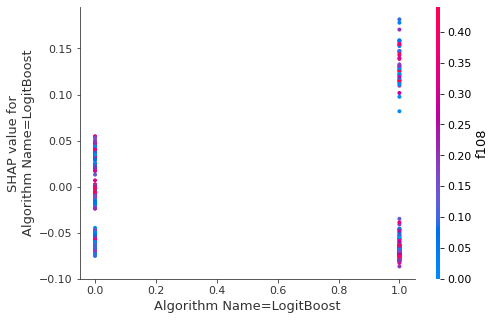

In [70]:
shap.initjs()
shap.dependence_plot('Algorithm Name=LogitBoost', shap_values[1], X_encoded, interaction_index="f108", feature_names=dv.get_feature_names())

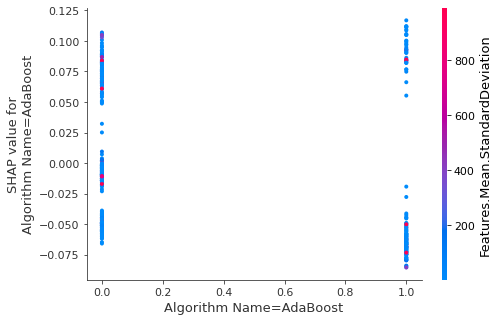

In [71]:
shap.initjs()
shap.dependence_plot('Algorithm Name=AdaBoost', shap_values[1], X_encoded, interaction_index="Features.Mean.StandardDeviation", feature_names=dv.get_feature_names())

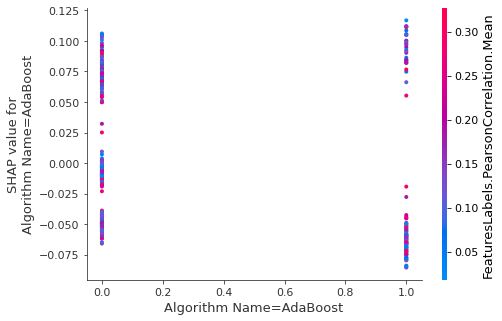

In [72]:
shap.initjs()
shap.dependence_plot('Algorithm Name=AdaBoost', shap_values[1], X_encoded, interaction_index="FeaturesLabels.PearsonCorrelation.Mean", feature_names=dv.get_feature_names())

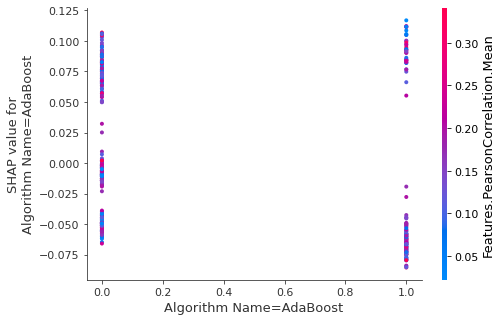

In [73]:
shap.initjs()
shap.dependence_plot('Algorithm Name=AdaBoost', shap_values[1], X_encoded, interaction_index="Features.PearsonCorrelation.Mean", feature_names=dv.get_feature_names())

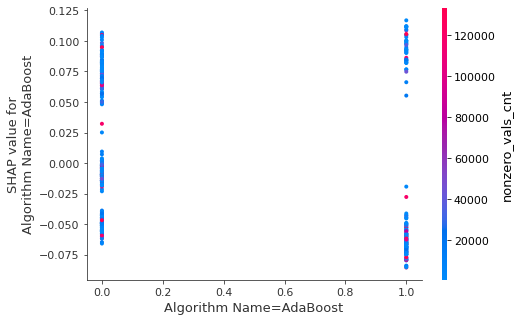

In [74]:
shap.initjs()
shap.dependence_plot('Algorithm Name=AdaBoost', shap_values[1], X_encoded, interaction_index="nonzero_vals_cnt", feature_names=dv.get_feature_names())

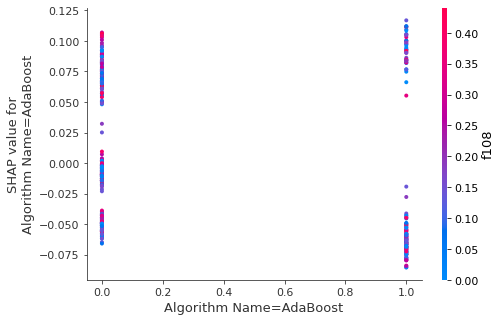

In [75]:
shap.initjs()
shap.dependence_plot('Algorithm Name=AdaBoost', shap_values[1], X_encoded, interaction_index="f108", feature_names=dv.get_feature_names())